Import relevant libraries

In [1]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import soundfile as sf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.preprocessing
from sklearn import svm, metrics
from statistics import mean
import numpy as np
import scipy.stats
import scipy.signal
import pandas as pd
import os
from scipy.stats import skew, kurtosis
#import elm
from scipy.signal import butter,filtfilt
import seaborn as sns

import MusicUtilities as MU


Code to extract all the features once (Takes ~20min for all features)

In [3]:
# set local file path
basepath = "C:\\Users\\kseni\\ISYE6740_Music_Analysis"
# set full list of features to create
feat_dict = {'MFCC':False,
             'ECFZ':True,
             'BeatHist':False,
             'STP':False}
# Uncomment the item below to run the feature extraction
#success = MU.create_feature_files(basepath,feat_dict)

Load the data

In [2]:
# set local file path
basepath = "C:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis"

# Load the full feature set of data
feat_list = ['MFCC','ECFZ','BeatHist','STP']  
feat_dict = {f:True for f in feat_list}
data = MU.get_music_features(basepath,feat_dict)
print("Shape of music data:",data.shape)

# Load the class labels
label_data = pd.read_csv("features\\musiclabels.csv",header=None)
label_array = np.array(label_data[0]).flatten()

# Scale the data
scaler = sklearn.preprocessing.StandardScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into train/test sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_scaled, label_array.T, test_size=0.2, random_state=1)


Shape of music data: (999, 169)


Initial model tuning and parameter setting with all data

In [3]:
#Tuning the number of neighbors for KNN
knn = KNeighborsClassifier()
#List of values to test 
parameter = {"n_neighbors":[3, 5, 7, 9, 11, 13, 15]}
grid_search = GridSearchCV(knn, parameter, cv=5)
#Fit model to the training data
knn_model = grid_search.fit(Xtrain, Ytrain)
# Print the best hyperparameter value found by the grid search
print(grid_search.best_params_)


{'n_neighbors': 9}


In [4]:
#Tuning the SVM (regularization parameter C)
svm = LinearSVC(max_iter=10000)
# Define the values of the regularization parameter C to test 
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
svm_grid_search = GridSearchCV(svm, parameters, cv=5)
svm_grid_search.fit(Xtrain, Ytrain)
# Print the best hyperparameter value 
print(svm_grid_search.best_params_)

c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the numb

{'C': 0.01}


In [6]:
#Tuning non-linear (kernel) SVM
kern_svm = SVC()
# Define the hyperparameters to tune
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
kern_svm_grid_search = GridSearchCV(kern_svm, parameters, cv=5)
#Fit to data
kern_svm_grid_search.fit(Xtrain, Ytrain)
# Print the best hyperparameter values 
print(kern_svm_grid_search.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [7]:
#Tuning Neural Networks 
# define the parameter grid
parameters = {
    'hidden_layer_sizes': [(67,), (68,), (69,), (70,), (71,), (72,), (70,70), (71,71)],
    #'activation': ['logistic', 'tanh', 'relu'],
    #'solver': ['sgd', 'adam'],
    #'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
}

# create the MLPClassifier
NN = MLPClassifier(max_iter=10000)

# create the GridSearchCV object
grid = GridSearchCV(NN, parameters, cv=5, scoring='accuracy')

# fit the GridSearchCV object to the data
grid.fit(Xtrain, Ytrain)

# print the best hyperparameters and corresponding accuracy score
print("Best parameters: ", grid.best_params_)
print("Best accuracy: ", grid.best_score_)

Best parameters:  {'hidden_layer_sizes': (70,), 'learning_rate': 'adaptive'}
Best accuracy:  0.7184198113207547


Train and run ELM (Extreme Learning Machine) classifier

(not sklearn so it requires a different run structure)

In [ ]:

genredict = {'blues':0,
             'classical':1,
             'country':2,
             'disco':3,
             'hiphop':4,
             'jazz':5,
             'metal':6,
             'pop':7,
             'reggae':8,
             'rock':9}

# create an ELM (Extreme Learning Machine) classifier
# first add the class labels as the first column of the data
Yt3 = np.array([genredict[g] for g in Ytrain]).reshape((799,1))
elmdata = np.concatenate((Yt3,Xtrain),axis=1)
# then run the ELM model
params=['sigmoid',1,500,False]
elmk = elm.ELMRandom(params)
#elmk.search_param(elmdata,cv='kfold',of='accuracy',eval=10)
elm_result = elmk.train(elmdata)
elm_accuracy = elm_result.get_accuracy()
print("Testing accuracy of ELM", elm_accuracy)
print("#######################################################")


Experiment Structure

In [33]:
# set local file path
#basepath = "C:\\Users\\kseni\\ISYE6740_Music_Analysis"

# Build DOE matrix of feature sets to try
doe_matrix = pd.read_csv("DOE_matrix.csv",index_col=0)

# Load the class labels
label_data = pd.read_csv("features\\musiclabels.csv",header=None)
label_array = np.array(label_data).flatten()

# Establish other parameters and tuning options
n_cv = 10
feat_list = [f for f in doe_matrix.columns]

modelnames = ["KNN", "Logistic Regression", "SVM", "Kernel SVM", "Bagging_kernSVM", "Neural Networks", "Bagging NN", 
              "Random Forest", "Boosted Decision Tree", "Boosted Kernel SVM" ]
classifiers = [KNeighborsClassifier(grid_search.best_params_['n_neighbors']),
               LogisticRegression(max_iter=10000),
               LinearSVC(C=svm_grid_search.best_params_['C'], max_iter=10000),
               SVC(C=kern_svm_grid_search.best_params_['C'], kernel=kern_svm_grid_search.best_params_['kernel'], max_iter=10000),
               BaggingClassifier(SVC(C=kern_svm_grid_search.best_params_['C'], kernel=kern_svm_grid_search.best_params_['kernel'], 
                                     max_iter=10000), n_estimators=10),
               MLPClassifier(hidden_layer_sizes=(72, ),  activation='relu', solver='adam', alpha=0.0001, 
                             learning_rate='constant',max_iter=10000),
               BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(72, ),  activation='relu', solver='adam', 
                                                              alpha=0.0001, learning_rate='constant',max_iter=10000), 
                                 n_estimators=10, max_samples=0.5),         
               RandomForestClassifier(n_estimators=100),
               AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=7),                                                     
                                  n_estimators=70),
               AdaBoostClassifier(estimator=SVC(C=kern_svm_grid_search.best_params_['C'], kernel=kern_svm_grid_search.best_params_['kernel'], 
                                                max_iter=10000),                                                     
                                  n_estimators=70, algorithm='SAMME')
               
              ]
cf_dict = dict(zip(modelnames, classifiers))



In [ ]:

# for each DOE combination
for d in range(1,doe_matrix.shape[0]+1):

  results = []
  # set the desired features
  feat_dict = {f:bool(doe_matrix[f][d]) for f in feat_list}
  print("DOE run",d,feat_dict)

  # Load features according to DOE
  data = MU.get_music_features(basepath,feat_dict)
  print("Shape of music data:",data.shape)

  # Scale the data
  scaler = sklearn.preprocessing.StandardScaler()
  data_scaled = scaler.fit_transform(data)

  # Split the data into train/test sets
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_scaled, label_array.T, test_size=0.2, random_state=1+d)
  data_array = [Xtrain, Xtest, Ytrain, Ytest]

  # Train models in CV loops
  # TODO add CV loops here rather than running just once
  #   and analyze the results:
  #   Mean accuracy of each model + feature-set
  #   Mean range/impact of each feature-set
  for model in modelnames:
    _, _, accy = MU.run_classification(model,cf_dict,data_array,verbose=False)
    results.append(accy)
    print("Accuracy of", model, "is", round(accy * 100, 1), "%")

  
  bestaccy_ind = np.argmax(results)
  bestaccy = results[bestaccy_ind]
  bestmodel = modelnames[bestaccy_ind]
  print("DOE run",d,"best accuracy:",round(bestaccy*100,1),"% with model",bestmodel)

  # Report summarized metrics
  # Print the confusion matrix for the best model
  clf = cf_dict[bestmodel]
  clf.fit(Xtrain,Ytrain)
  predicted = clf.predict(Xtest)
  print("Confusion matrix for best model:")
  cf_matrix = metrics.confusion_matrix(Ytest, predicted)
  sns.heatmap(cf_matrix, annot=True, cmap='Blues')
  plt.show()




In [ ]:
import MusicUtilities as MU
# sample feature extraction
audio_path2 = 'GTZAN_data\\metal\\metal.00008.wav'
x, sr = librosa.load(audio_path2,sr=22050)

mfccs = MU.get_mfcc_features(x,sr)
ecfzs = MU.get_ecfz_features(x,sr)
stps = MU.get_stp_features(x,sr)
bfs = MU.get_beat_features(x,sr)
data = np.concatenate((mfccs,ecfzs,bfs,stps))

print("Shape of data features", data.shape)
print(ecfzs)

DOE run 1 {'MFCC': False, 'ECFZ': False, 'BeatHist': True, 'STP': True}
Skipping feature MFCC as requested
Skipping feature ECFZ as requested
Shape of music data: (999, 19)
Accuracy of KNN is 30.5 %
Accuracy of Logistic Regression is 27.5 %
Accuracy of SVM is 23.0 %
Accuracy of Kernel SVM is 34.5 %
Accuracy of Neural Networks is 34.5 %
Accuracy of Random Forest is 38.5 %
DOE run 1 best accuracy: 38.5 % with model Random Forest
Confusion matrix for best model:


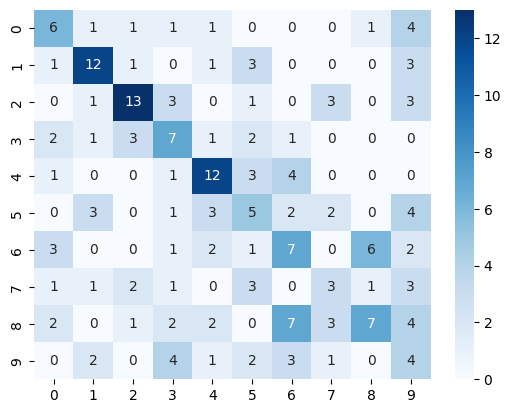

DOE run 2 {'MFCC': True, 'ECFZ': False, 'BeatHist': True, 'STP': False}
Skipping feature ECFZ as requested
Skipping feature STP as requested
Shape of music data: (999, 120)
Accuracy of KNN is 55.5 %
Accuracy of Logistic Regression is 62.0 %
Accuracy of SVM is 56.5 %
Accuracy of Kernel SVM is 64.0 %
Accuracy of Neural Networks is 61.0 %
Accuracy of Random Forest is 65.5 %
DOE run 2 best accuracy: 65.5 % with model Random Forest
Confusion matrix for best model:


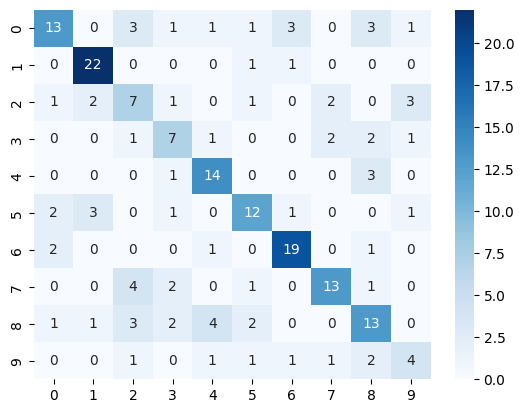

DOE run 3 {'MFCC': True, 'ECFZ': False, 'BeatHist': False, 'STP': True}
Skipping feature ECFZ as requested
Skipping feature BeatHist as requested
Shape of music data: (999, 127)
Accuracy of KNN is 56.0 %
Accuracy of Logistic Regression is 66.5 %
Accuracy of SVM is 59.0 %
Accuracy of Kernel SVM is 65.0 %
Accuracy of Neural Networks is 66.5 %
Accuracy of Random Forest is 64.0 %
DOE run 3 best accuracy: 66.5 % with model Logistic Regression
Confusion matrix for best model:


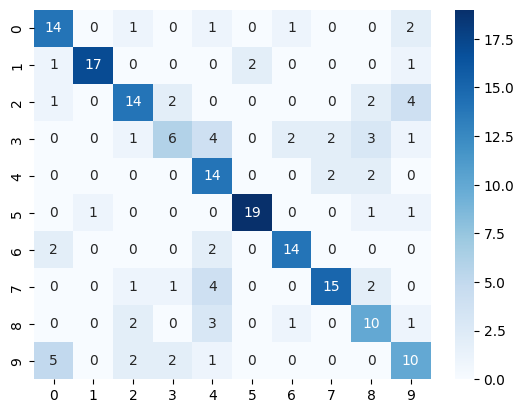

DOE run 4 {'MFCC': False, 'ECFZ': True, 'BeatHist': True, 'STP': False}
Skipping feature MFCC as requested
Skipping feature STP as requested
Shape of music data: (999, 42)
Accuracy of KNN is 60.5 %
Accuracy of Logistic Regression is 63.0 %
Accuracy of SVM is 59.0 %
Accuracy of Kernel SVM is 64.0 %
Accuracy of Neural Networks is 67.5 %
Accuracy of Random Forest is 69.5 %
DOE run 4 best accuracy: 69.5 % with model Random Forest
Confusion matrix for best model:


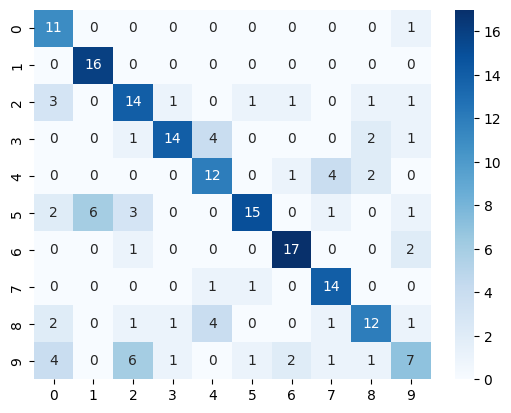

DOE run 5 {'MFCC': True, 'ECFZ': True, 'BeatHist': False, 'STP': False}
Skipping feature BeatHist as requested
Skipping feature STP as requested
Shape of music data: (999, 150)
Accuracy of KNN is 60.0 %
Accuracy of Logistic Regression is 68.5 %
Accuracy of SVM is 67.0 %
Accuracy of Kernel SVM is 72.5 %
Accuracy of Neural Networks is 74.0 %
Accuracy of Random Forest is 73.0 %
DOE run 5 best accuracy: 74.0 % with model Neural Networks
Confusion matrix for best model:


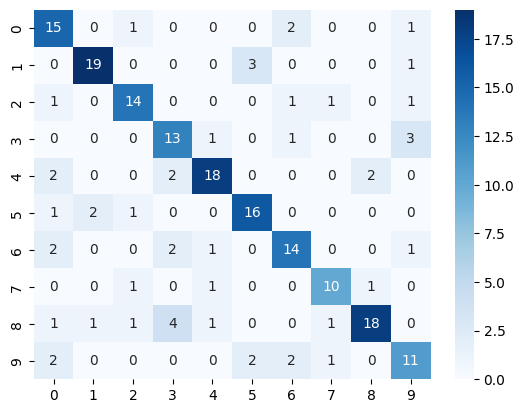

DOE run 6 {'MFCC': True, 'ECFZ': True, 'BeatHist': True, 'STP': True}
Shape of music data: (999, 169)
Accuracy of KNN is 62.5 %
Accuracy of Logistic Regression is 67.5 %
Accuracy of SVM is 61.0 %
Accuracy of Kernel SVM is 69.0 %
Accuracy of Neural Networks is 70.5 %
Accuracy of Random Forest is 67.5 %
DOE run 6 best accuracy: 70.5 % with model Neural Networks
Confusion matrix for best model:


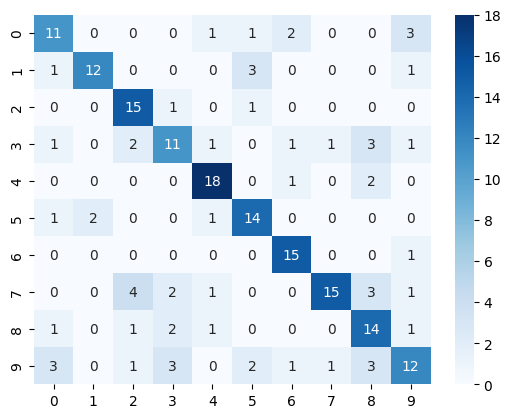

DOE run 7 {'MFCC': False, 'ECFZ': True, 'BeatHist': False, 'STP': True}
Skipping feature MFCC as requested
Skipping feature BeatHist as requested
Shape of music data: (999, 49)
Accuracy of KNN is 58.0 %
Accuracy of Logistic Regression is 70.5 %
Accuracy of SVM is 70.5 %
Accuracy of Kernel SVM is 68.0 %
Accuracy of Neural Networks is 67.0 %
Accuracy of Random Forest is 67.5 %
DOE run 7 best accuracy: 70.5 % with model Logistic Regression
Confusion matrix for best model:


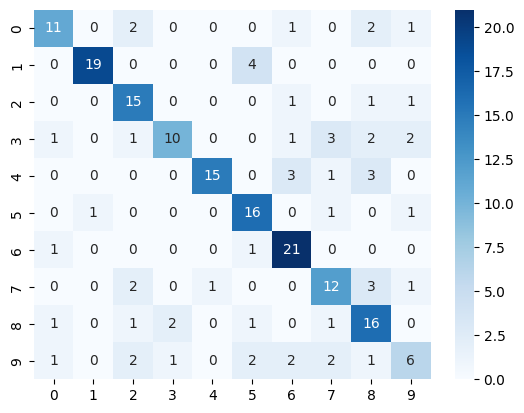

DOE run 8 {'MFCC': True, 'ECFZ': True, 'BeatHist': True, 'STP': False}
Skipping feature STP as requested
Shape of music data: (999, 156)
Accuracy of KNN is 66.5 %
Accuracy of Logistic Regression is 72.5 %
Accuracy of SVM is 70.0 %
Accuracy of Kernel SVM is 76.0 %
Accuracy of Neural Networks is 78.5 %
Accuracy of Random Forest is 70.0 %
DOE run 8 best accuracy: 78.5 % with model Neural Networks
Confusion matrix for best model:


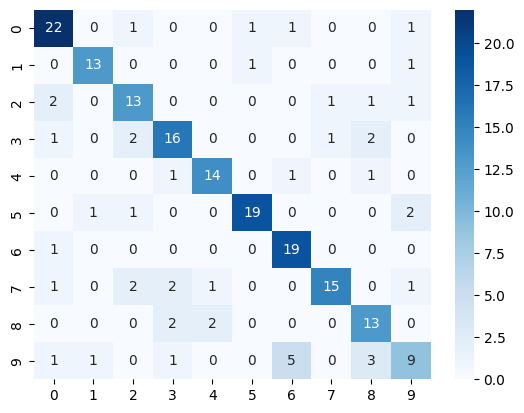

In [31]:
#Experimenting with default classifiers' settings
# set local file path
#basepath = "C:\\Users\\kseni\\ISYE6740_Music_Analysis"

# Build DOE matrix of feature sets to try
doe_matrix = pd.read_csv("DOE_matrix.csv",index_col=0)

# Load the class labels
label_data = pd.read_csv("features\\musiclabels.csv",header=None)
label_array = np.array(label_data).flatten()

# Establish other parameters and tuning options
n_cv = 10
feat_list = [f for f in doe_matrix.columns]

modelnames = ["KNN", "Logistic Regression", "SVM", "Kernel SVM", "Neural Networks", "Random Forest"]
classifiers = [KNeighborsClassifier(),
               LogisticRegression(max_iter=10000),
               LinearSVC(max_iter=10000),
               SVC(max_iter=10000),
               #BaggingClassifier(SVC(C=svm_grid_search.best_params_['C'], kernel=svm_grid_search.best_params_['kernel'], 
                                     #max_iter=10000), n_estimators=10),
               MLPClassifier(max_iter=10000),
               #BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes=(72, ),  activation='relu', solver='adam', 
                                                              #alpha=0.0001, learning_rate='constant',max_iter=10000), 
                                 #n_estimators=10, max_samples=0.5),         
               RandomForestClassifier(),
               #AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=7),                                                     
                                  #n_estimators=70),
               #AdaBoostClassifier(estimator=SVC(C=svm_grid_search.best_params_['C'], kernel=svm_grid_search.best_params_['kernel'], 
                                                #max_iter=10000),                                                     
                                  #n_estimators=70, algorithm='SAMME')
               
              ]
cf_dict = dict(zip(modelnames, classifiers))


# for each DOE combination
for d in range(1,doe_matrix.shape[0]+1):

  results = []
  # set the desired features
  feat_dict = {f:bool(doe_matrix[f][d]) for f in feat_list}
  print("DOE run",d,feat_dict)

  # Load features according to DOE
  data = MU.get_music_features(basepath,feat_dict)
  print("Shape of music data:",data.shape)

  # Scale the data
  scaler = sklearn.preprocessing.StandardScaler()
  data_scaled = scaler.fit_transform(data)

  # Split the data into train/test sets
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_scaled, label_array.T, test_size=0.2, random_state=1+d)
  data_array = [Xtrain, Xtest, Ytrain, Ytest]

  # Train models in CV loops
  # TODO add CV loops here rather than running just once
  #   and analyze the results:
  #   Mean accuracy of each model + feature-set
  #   Mean range/impact of each feature-set
  for model in modelnames:
    _, _, accy = MU.run_classification(model,cf_dict,data_array,verbose=False)
    results.append(accy)
    print("Accuracy of", model, "is", round(accy * 100, 1), "%")

  
  bestaccy_ind = np.argmax(results)
  bestaccy = results[bestaccy_ind]
  bestmodel = modelnames[bestaccy_ind]
  print("DOE run",d,"best accuracy:",round(bestaccy*100,1),"% with model",bestmodel)

  # Report summarized metrics
  # Print the confusion matrix for the best model
  clf = cf_dict[bestmodel]
  clf.fit(Xtrain,Ytrain)
  predicted = clf.predict(Xtest)
  print("Confusion matrix for best model:")
  cf_matrix = metrics.confusion_matrix(Ytest, predicted)
  sns.heatmap(cf_matrix, annot=True, cmap='Blues')
  plt.show()




DOE run 8 Cross-Validation:  All Feature-Sets except STP

DOE run 8 {'MFCC': True, 'ECFZ': True, 'BeatHist': True, 'STP': False}
Skipping feature STP as requested
Shape of music data: (999, 156)
Average accuracy of KNN is 61.8 %
Average accuracy of Logistic Regression is 66.1 %
Average accuracy of SVM is 68.2 %
Average accuracy of Kernel SVM is 74.3 %
Average accuracy of Bagging_kernSVM is 73.7 %
Average accuracy of Neural Networks is 69.2 %


c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\en

Average accuracy of Bagging NN is 68.3 %
Average accuracy of Random Forest is 68.1 %
Average accuracy of Boosted Decision Tree is 65.6 %
Average accuracy of Boosted Kernel SVM is 11.9 %


<Figure size 1200x600 with 0 Axes>

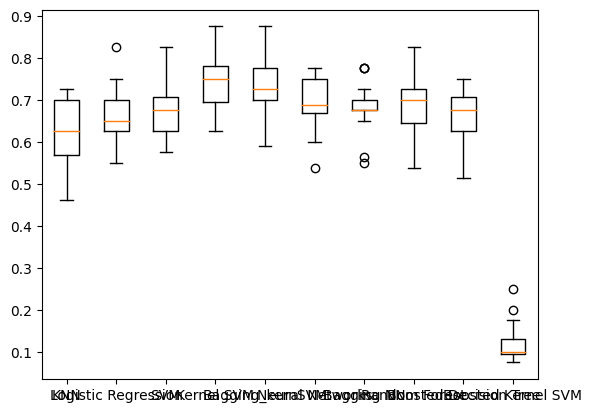

DOE run 8 best accuracy: 74.3 % with model Kernel SVM
Confusion matrix for best model:


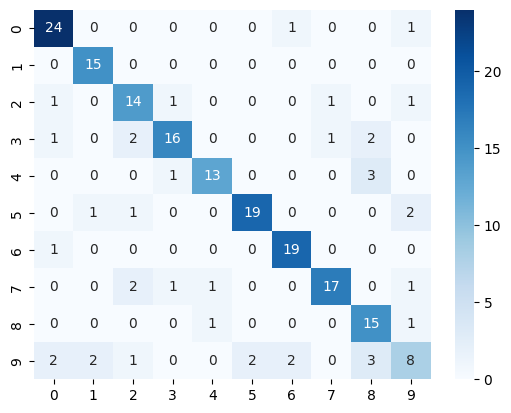

In [34]:
# Performing cross-validation for the DOE setup 8
from sklearn.model_selection import cross_val_score

# for DOE combination 8
d = doe_matrix.shape[0]

results = {}
# set the desired features
feat_dict = {f:bool(doe_matrix[f][d]) for f in feat_list}
print("DOE run",d,feat_dict)

# Load features according to DOE
data = MU.get_music_features(basepath,feat_dict)
print("Shape of music data:",data.shape)

# Scale the data
scaler = sklearn.preprocessing.StandardScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into train/test sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_scaled, label_array.T, test_size=0.2, random_state=1+d)

# Train models in CV loops
for model in modelnames:
    clf = cf_dict[model]
    cv_scores = cross_val_score(clf, Xtrain, Ytrain, cv=20)
    results[model] = cv_scores.tolist()
    print("Average accuracy of", model, "is", round(cv_scores.mean() * 100, 1), "%")

# Plot box plots for each model
plt.figure(figsize=(12,6))
fig, ax = plt.subplots()
ax.boxplot(list(results.values()))
ax.set_xticklabels(results.keys())
plt.show()

bestaccy_ind = np.argmax([np.mean(v) for v in results.values()])
bestaccy = np.mean(results[modelnames[bestaccy_ind]])
bestmodel = modelnames[bestaccy_ind]
print("DOE run",d,"best accuracy:",round(bestaccy*100,1),"% with model",bestmodel)

# Print the confusion matrix for the best model
clf = cf_dict[bestmodel]
clf.fit(Xtrain,Ytrain)
predicted = clf.predict(Xtest)
print("Confusion matrix for best model:")
cf_matrix = metrics.confusion_matrix(Ytest, predicted)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.show()


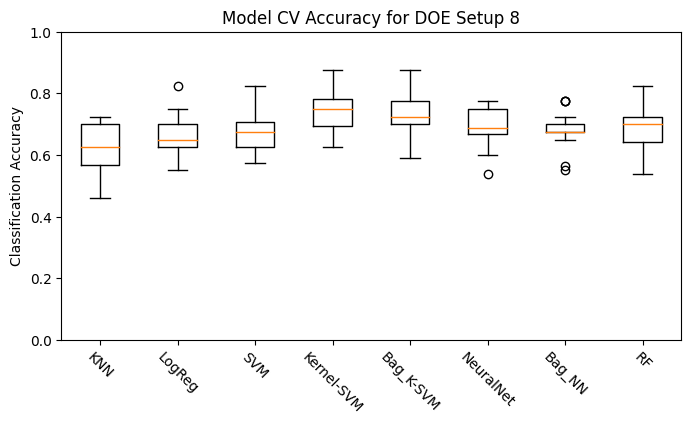

In [57]:
labels = ['KNN','LogReg','SVM','Kernel-SVM','Bag_K-SVM','NeuralNet','Bag_NN','RF']
# Plot box plots for each model
fig, ax = plt.subplots(figsize=(8,4))
ax.boxplot(list(results.values())[:8])
ax.set_xticklabels(labels,rotation=-45)
ax.set_ylabel("Classification Accuracy")
ax.set_ybound(0,1)
ax.set_title("Model CV Accuracy for DOE Setup 8")
plt.show()


DOE run 6 Cross-Validation:  All feature-sets

DOE run 6 {'MFCC': True, 'ECFZ': True, 'BeatHist': True, 'STP': True}
Shape of music data: (999, 169)
Average accuracy of KNN is 61.5 %
Average accuracy of Logistic Regression is 70.8 %
Average accuracy of SVM is 72.1 %
Average accuracy of Kernel SVM is 72.7 %
Average accuracy of Bagging_kernSVM is 72.3 %
Average accuracy of Neural Networks is 71.0 %


C:\Users\kseni\anaconda3\envs\rosa\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\kseni\anaconda3\envs\rosa\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\kseni\anaconda3\envs\rosa\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\kseni\anaconda3\envs\rosa\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\kseni\anaconda3\envs\rosa\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  

Average accuracy of Bagging NN is 70.3 %
Average accuracy of Random Forest is 69.3 %
Average accuracy of Boosted Decision Tree is 64.6 %
Average accuracy of Boosted Kernel SVM is 16.1 %


<Figure size 1800x600 with 0 Axes>

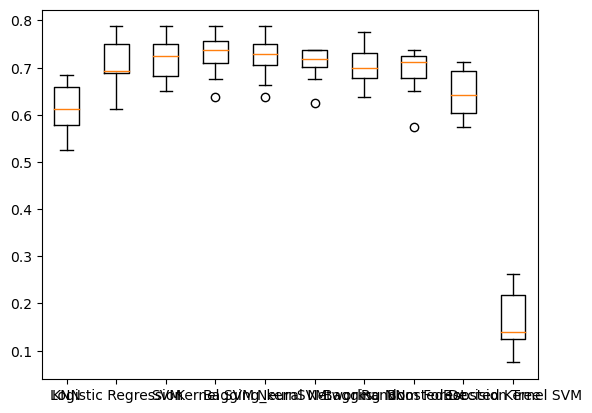

DOE run 6 best accuracy: 72.7 % with model Kernel SVM
Confusion matrix for best model:


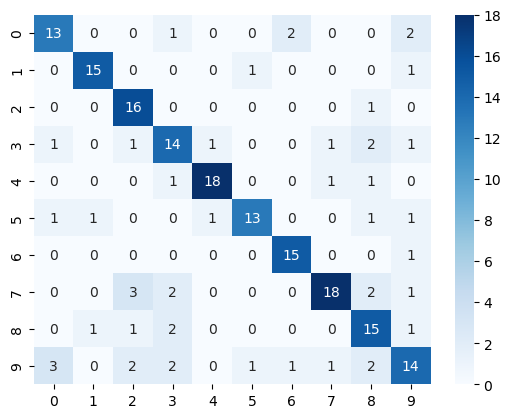

In [16]:
# Performing cross-validation for the DOE setup 6
from sklearn.model_selection import cross_val_score

# for DOE combination 6
d = 6

results = {}
# set the desired features
feat_dict = {f:bool(doe_matrix[f][d]) for f in feat_list}
print("DOE run",d,feat_dict)

# Load features according to DOE
data = MU.get_music_features(basepath,feat_dict)
print("Shape of music data:",data.shape)

# Scale the data
scaler = sklearn.preprocessing.StandardScaler()
data_scaled = scaler.fit_transform(data)

# Split the data into train/test sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data_scaled, label_array.T, test_size=0.2, random_state=1+d)

# Train models in CV loops
for model in modelnames:
    clf = cf_dict[model]
    cv_scores = cross_val_score(clf, Xtrain, Ytrain, cv=10)
    results[model] = cv_scores.tolist()
    print("Average accuracy of", model, "is", round(cv_scores.mean() * 100, 1), "%")

# Plot box plots for each model
plt.figure(figsize=(18,6))
fig, ax = plt.subplots()
ax.boxplot(list(results.values()))
ax.set_xticklabels(results.keys())
plt.show()

bestaccy_ind = np.argmax([np.mean(v) for v in results.values()])
bestaccy = np.mean(results[modelnames[bestaccy_ind]])
bestmodel = modelnames[bestaccy_ind]
print("DOE run",d,"best accuracy:",round(bestaccy*100,1),"% with model",bestmodel)

# Print the confusion matrix for the best model
clf = cf_dict[bestmodel]
clf.fit(Xtrain,Ytrain)
predicted = clf.predict(Xtest)
print("Confusion matrix for best model:")
cf_matrix = metrics.confusion_matrix(Ytest, predicted)
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.show()


Extract Features for Unknown Sample Files

In [10]:
unknowns = librosa.util.find_files('Genre_Samples_Converted')
print(unknowns[1])

# set local file path
basepath = "C:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis"
# set full list of features to create
feat_dict = {'MFCC':True,
             'ECFZ':True,
             'BeatHist':True,
             'STP':True}
# Uncomment the item below to run the feature extraction
success = MU.create_feature_files2(basepath,unknowns,feat_dict,verbose=True)

c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\Genre_Samples_Converted\Blues\02 Before You Accuse Me.Wav
01 He Don't Play Nothin' But The Blues.Wav
Processing file: Blues 01 He Don't Play Nothin' But The Blues.Wav
0.18705736 2122.000047925517 1.1849723 0.10242677236323967
2319.6570118115737 4428.124008471025 7180.589884907807 0.014736434 20.380985663236263
02 Before You Accuse Me.Wav
Processing file: Blues 02 Before You Accuse Me.Wav
0.12329535 2484.8969012409934 1.1966155 0.12822060970396332
2482.474111335477 5304.797662920224 7733.383427127043 0.0360153 19.973207884179402
03 Back Door Santa.Wav
Processing file: Blues 03 Back Door Santa.Wav
0.21813215 2033.318003025672 1.4627424 0.08994316186797753
2279.6995756654346 4268.9889725245785 6988.326465392381 0.012534234 20.645875918528574
09 (Let Me Up) I've Had Enough.Wav
Processing file: Blues 09 (Let Me Up) I've Had Enough.Wav
0.17124145 2378.6847170847855 1.2637806 0.11219812201644272
2536.036992884805 5211.079319113552 7963.149

Load Features for Unknown Sample Files

In [15]:
# set local file path
basepath = "C:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis"
# Load the full feature set of data
feat_list = ['MFCC','ECFZ','BeatHist','STP']  
feat_dict = {f:True for f in feat_list}
v_data = MU.get_music_features2(basepath,feat_dict)
print("Shape of music data:",v_data.shape)

# Load the class labels
label_data = pd.read_csv("features2\\musiclabels2.csv",header=None)
Yvalid = np.array(label_data[0]).flatten()

# Scale the data
scaler = sklearn.preprocessing.StandardScaler()
Xvalid = scaler.fit_transform(v_data)



Shape of music data: (28, 169)


Estimate Genre for Unknown Files

0 Actual: blues | Predicted: rock | 01 He Don't Play Nothin' 
1 Actual: blues | Predicted: hiphop | 02 Before You Accuse Me.W
2 Actual: blues | Predicted: hiphop | 03 Back Door Santa.Wav
3 Actual: blues | Predicted: disco | 09 (Let Me Up) I've Had E
4 Actual: blues | Predicted: country | 1-10 Worried Down With Th
5 Actual: classical | Predicted: classical | 03 Vivaldi_ Gloria - Laud
6 Actual: classical | Predicted: country | 04 Mozart_ The Marriage O
7 Actual: classical | Predicted: classical | 05 Dvorák_ Rondo For Cell
8 Actual: classical | Predicted: metal | 07 Partita No. 2 d-moll, 
9 Actual: classical | Predicted: jazz | 14 Bach_ Magnificat - Et 
10 Actual: jazz | Predicted: reggae | 04 Satin Doll.Wav
11 Actual: jazz | Predicted: jazz | 05 How High The Moon.Wav
12 Actual: jazz | Predicted: country | 06 Minor Swing.Wav
13 Actual: jazz | Predicted: jazz | 08 The Oneness Of Two (In
14 Actual: jazz | Predicted: reggae | 12 Take The 'A' Train.Wav
15 Actual: metal | Predicted: disco | 01

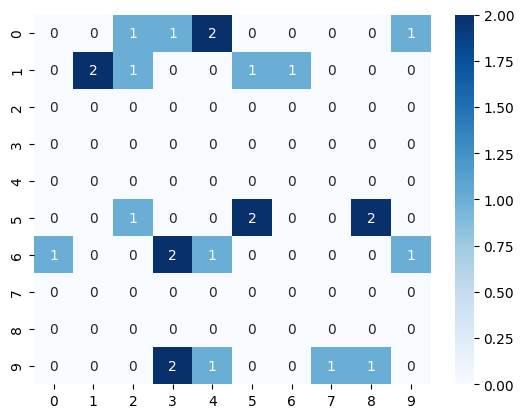

0 Actual: blues | Predicted: blues | 01 He Don't Play Nothin' 
1 Actual: blues | Predicted: rock | 02 Before You Accuse Me.W
2 Actual: blues | Predicted: hiphop | 03 Back Door Santa.Wav
3 Actual: blues | Predicted: disco | 09 (Let Me Up) I've Had E
4 Actual: blues | Predicted: country | 1-10 Worried Down With Th
5 Actual: classical | Predicted: classical | 03 Vivaldi_ Gloria - Laud
6 Actual: classical | Predicted: classical | 04 Mozart_ The Marriage O
7 Actual: classical | Predicted: classical | 05 Dvorák_ Rondo For Cell
8 Actual: classical | Predicted: classical | 07 Partita No. 2 d-moll, 
9 Actual: classical | Predicted: classical | 14 Bach_ Magnificat - Et 
10 Actual: jazz | Predicted: reggae | 04 Satin Doll.Wav
11 Actual: jazz | Predicted: jazz | 05 How High The Moon.Wav
12 Actual: jazz | Predicted: reggae | 06 Minor Swing.Wav
13 Actual: jazz | Predicted: jazz | 08 The Oneness Of Two (In
14 Actual: jazz | Predicted: reggae | 12 Take The 'A' Train.Wav
15 Actual: metal | Predicted: m

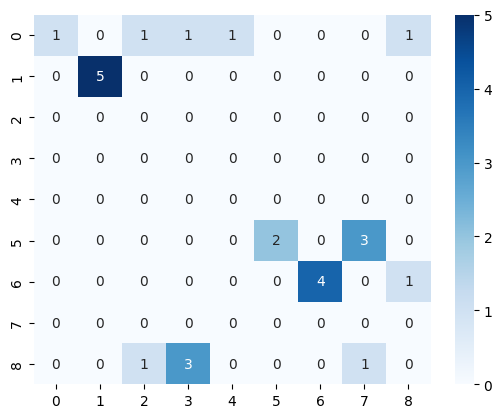

0 Actual: blues | Predicted: jazz | 01 He Don't Play Nothin' 
1 Actual: blues | Predicted: rock | 02 Before You Accuse Me.W
2 Actual: blues | Predicted: hiphop | 03 Back Door Santa.Wav
3 Actual: blues | Predicted: disco | 09 (Let Me Up) I've Had E
4 Actual: blues | Predicted: country | 1-10 Worried Down With Th
5 Actual: classical | Predicted: classical | 03 Vivaldi_ Gloria - Laud
6 Actual: classical | Predicted: classical | 04 Mozart_ The Marriage O
7 Actual: classical | Predicted: classical | 05 Dvorák_ Rondo For Cell
8 Actual: classical | Predicted: hiphop | 07 Partita No. 2 d-moll, 
9 Actual: classical | Predicted: classical | 14 Bach_ Magnificat - Et 
10 Actual: jazz | Predicted: jazz | 04 Satin Doll.Wav
11 Actual: jazz | Predicted: jazz | 05 How High The Moon.Wav
12 Actual: jazz | Predicted: reggae | 06 Minor Swing.Wav
13 Actual: jazz | Predicted: jazz | 08 The Oneness Of Two (In
14 Actual: jazz | Predicted: jazz | 12 Take The 'A' Train.Wav
15 Actual: metal | Predicted: metal | 0

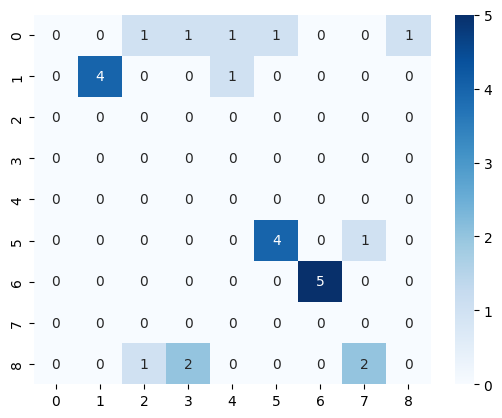

0 Actual: blues | Predicted: blues | 01 He Don't Play Nothin' 
1 Actual: blues | Predicted: disco | 02 Before You Accuse Me.W
2 Actual: blues | Predicted: hiphop | 03 Back Door Santa.Wav
3 Actual: blues | Predicted: disco | 09 (Let Me Up) I've Had E
4 Actual: blues | Predicted: reggae | 1-10 Worried Down With Th
5 Actual: classical | Predicted: classical | 03 Vivaldi_ Gloria - Laud
6 Actual: classical | Predicted: jazz | 04 Mozart_ The Marriage O
7 Actual: classical | Predicted: classical | 05 Dvorák_ Rondo For Cell
8 Actual: classical | Predicted: blues | 07 Partita No. 2 d-moll, 
9 Actual: classical | Predicted: classical | 14 Bach_ Magnificat - Et 
10 Actual: jazz | Predicted: blues | 04 Satin Doll.Wav
11 Actual: jazz | Predicted: blues | 05 How High The Moon.Wav
12 Actual: jazz | Predicted: reggae | 06 Minor Swing.Wav
13 Actual: jazz | Predicted: jazz | 08 The Oneness Of Two (In
14 Actual: jazz | Predicted: jazz | 12 Take The 'A' Train.Wav
15 Actual: metal | Predicted: metal | 01 B

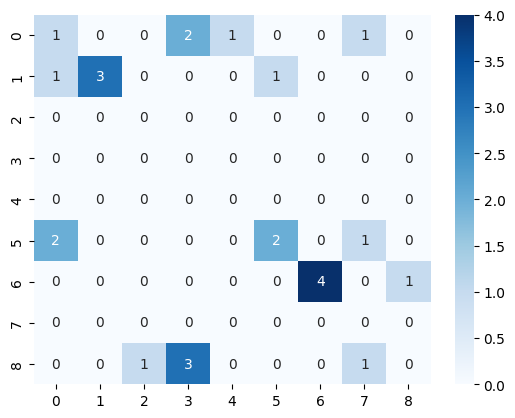

0 Actual: blues | Predicted: blues | 01 He Don't Play Nothin' 
1 Actual: blues | Predicted: disco | 02 Before You Accuse Me.W
2 Actual: blues | Predicted: hiphop | 03 Back Door Santa.Wav
3 Actual: blues | Predicted: disco | 09 (Let Me Up) I've Had E
4 Actual: blues | Predicted: reggae | 1-10 Worried Down With Th
5 Actual: classical | Predicted: classical | 03 Vivaldi_ Gloria - Laud
6 Actual: classical | Predicted: classical | 04 Mozart_ The Marriage O
7 Actual: classical | Predicted: classical | 05 Dvorák_ Rondo For Cell
8 Actual: classical | Predicted: classical | 07 Partita No. 2 d-moll, 
9 Actual: classical | Predicted: classical | 14 Bach_ Magnificat - Et 
10 Actual: jazz | Predicted: blues | 04 Satin Doll.Wav
11 Actual: jazz | Predicted: blues | 05 How High The Moon.Wav
12 Actual: jazz | Predicted: reggae | 06 Minor Swing.Wav
13 Actual: jazz | Predicted: jazz | 08 The Oneness Of Two (In
14 Actual: jazz | Predicted: jazz | 12 Take The 'A' Train.Wav
15 Actual: metal | Predicted: met

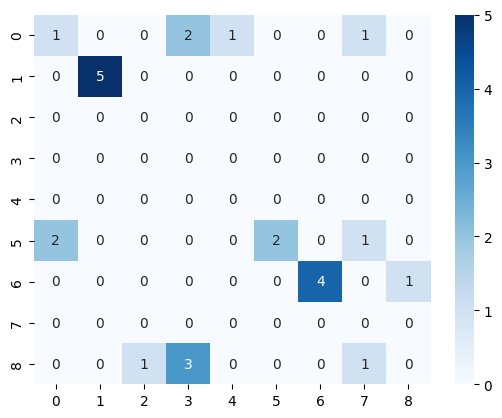

0 Actual: blues | Predicted: blues | 01 He Don't Play Nothin' 
1 Actual: blues | Predicted: hiphop | 02 Before You Accuse Me.W
2 Actual: blues | Predicted: hiphop | 03 Back Door Santa.Wav
3 Actual: blues | Predicted: disco | 09 (Let Me Up) I've Had E
4 Actual: blues | Predicted: rock | 1-10 Worried Down With Th
5 Actual: classical | Predicted: classical | 03 Vivaldi_ Gloria - Laud
6 Actual: classical | Predicted: classical | 04 Mozart_ The Marriage O
7 Actual: classical | Predicted: jazz | 05 Dvorák_ Rondo For Cell
8 Actual: classical | Predicted: metal | 07 Partita No. 2 d-moll, 
9 Actual: classical | Predicted: hiphop | 14 Bach_ Magnificat - Et 
10 Actual: jazz | Predicted: blues | 04 Satin Doll.Wav
11 Actual: jazz | Predicted: jazz | 05 How High The Moon.Wav
12 Actual: jazz | Predicted: reggae | 06 Minor Swing.Wav
13 Actual: jazz | Predicted: jazz | 08 The Oneness Of Two (In
14 Actual: jazz | Predicted: jazz | 12 Take The 'A' Train.Wav
15 Actual: metal | Predicted: metal | 01 Burnin

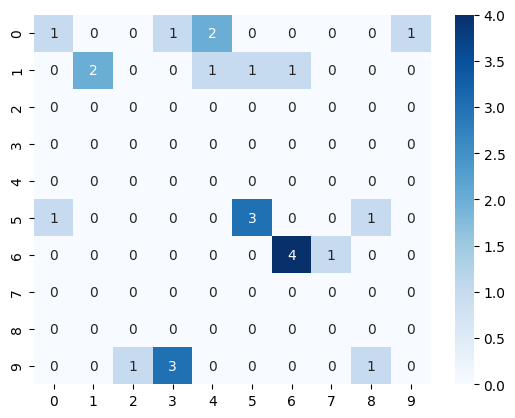

c:\GTMS Projects\ISYE6740 CDA\ISYE6740_Music_Analysis\.venv\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0 Actual: blues | Predicted: rock | 01 He Don't Play Nothin' 
1 Actual: blues | Predicted: hiphop | 02 Before You Accuse Me.W
2 Actual: blues | Predicted: hiphop | 03 Back Door Santa.Wav
3 Actual: blues | Predicted: disco | 09 (Let Me Up) I've Had E
4 Actual: blues | Predicted: hiphop | 1-10 Worried Down With Th
5 Actual: classical | Predicted: classical | 03 Vivaldi_ Gloria - Laud
6 Actual: classical | Predicted: classical | 04 Mozart_ The Marriage O
7 Actual: classical | Predicted: classical | 05 Dvorák_ Rondo For Cell
8 Actual: classical | Predicted: hiphop | 07 Partita No. 2 d-moll, 
9 Actual: classical | Predicted: classical | 14 Bach_ Magnificat - Et 
10 Actual: jazz | Predicted: jazz | 04 Satin Doll.Wav
11 Actual: jazz | Predicted: jazz | 05 How High The Moon.Wav
12 Actual: jazz | Predicted: reggae | 06 Minor Swing.Wav
13 Actual: jazz | Predicted: jazz | 08 The Oneness Of Two (In
14 Actual: jazz | Predicted: jazz | 12 Take The 'A' Train.Wav
15 Actual: metal | Predicted: metal | 

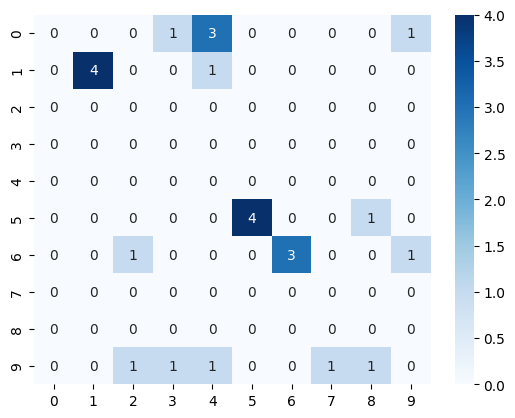

0 Actual: blues | Predicted: blues | 01 He Don't Play Nothin' 
1 Actual: blues | Predicted: hiphop | 02 Before You Accuse Me.W
2 Actual: blues | Predicted: hiphop | 03 Back Door Santa.Wav
3 Actual: blues | Predicted: disco | 09 (Let Me Up) I've Had E
4 Actual: blues | Predicted: hiphop | 1-10 Worried Down With Th
5 Actual: classical | Predicted: classical | 03 Vivaldi_ Gloria - Laud
6 Actual: classical | Predicted: classical | 04 Mozart_ The Marriage O
7 Actual: classical | Predicted: classical | 05 Dvorák_ Rondo For Cell
8 Actual: classical | Predicted: classical | 07 Partita No. 2 d-moll, 
9 Actual: classical | Predicted: classical | 14 Bach_ Magnificat - Et 
10 Actual: jazz | Predicted: blues | 04 Satin Doll.Wav
11 Actual: jazz | Predicted: blues | 05 How High The Moon.Wav
12 Actual: jazz | Predicted: jazz | 06 Minor Swing.Wav
13 Actual: jazz | Predicted: jazz | 08 The Oneness Of Two (In
14 Actual: jazz | Predicted: jazz | 12 Take The 'A' Train.Wav
15 Actual: metal | Predicted: disc

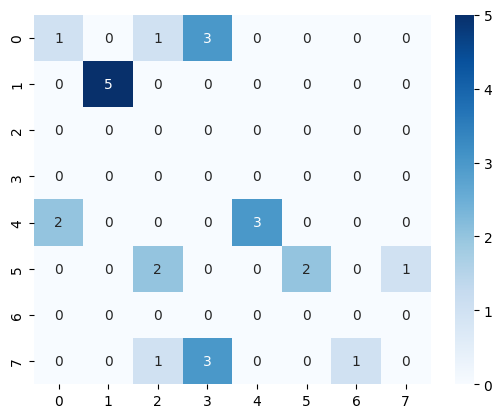

0 Actual: blues | Predicted: blues | 01 He Don't Play Nothin' 
1 Actual: blues | Predicted: reggae | 02 Before You Accuse Me.W
2 Actual: blues | Predicted: hiphop | 03 Back Door Santa.Wav
3 Actual: blues | Predicted: disco | 09 (Let Me Up) I've Had E
4 Actual: blues | Predicted: hiphop | 1-10 Worried Down With Th
5 Actual: classical | Predicted: classical | 03 Vivaldi_ Gloria - Laud
6 Actual: classical | Predicted: jazz | 04 Mozart_ The Marriage O
7 Actual: classical | Predicted: classical | 05 Dvorák_ Rondo For Cell
8 Actual: classical | Predicted: hiphop | 07 Partita No. 2 d-moll, 
9 Actual: classical | Predicted: classical | 14 Bach_ Magnificat - Et 
10 Actual: jazz | Predicted: jazz | 04 Satin Doll.Wav
11 Actual: jazz | Predicted: rock | 05 How High The Moon.Wav
12 Actual: jazz | Predicted: jazz | 06 Minor Swing.Wav
13 Actual: jazz | Predicted: rock | 08 The Oneness Of Two (In
14 Actual: jazz | Predicted: reggae | 12 Take The 'A' Train.Wav
15 Actual: metal | Predicted: disco | 01 B

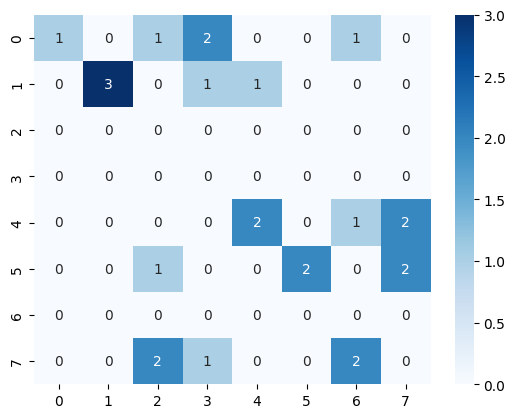

0 Actual: blues | Predicted: blues | 01 He Don't Play Nothin' 
1 Actual: blues | Predicted: reggae | 02 Before You Accuse Me.W
2 Actual: blues | Predicted: reggae | 03 Back Door Santa.Wav
3 Actual: blues | Predicted: country | 09 (Let Me Up) I've Had E
4 Actual: blues | Predicted: reggae | 1-10 Worried Down With Th
5 Actual: classical | Predicted: blues | 03 Vivaldi_ Gloria - Laud
6 Actual: classical | Predicted: blues | 04 Mozart_ The Marriage O
7 Actual: classical | Predicted: blues | 05 Dvorák_ Rondo For Cell
8 Actual: classical | Predicted: blues | 07 Partita No. 2 d-moll, 
9 Actual: classical | Predicted: blues | 14 Bach_ Magnificat - Et 
10 Actual: jazz | Predicted: blues | 04 Satin Doll.Wav
11 Actual: jazz | Predicted: blues | 05 How High The Moon.Wav
12 Actual: jazz | Predicted: country | 06 Minor Swing.Wav
13 Actual: jazz | Predicted: reggae | 08 The Oneness Of Two (In
14 Actual: jazz | Predicted: reggae | 12 Take The 'A' Train.Wav
15 Actual: metal | Predicted: metal | 01 Burn

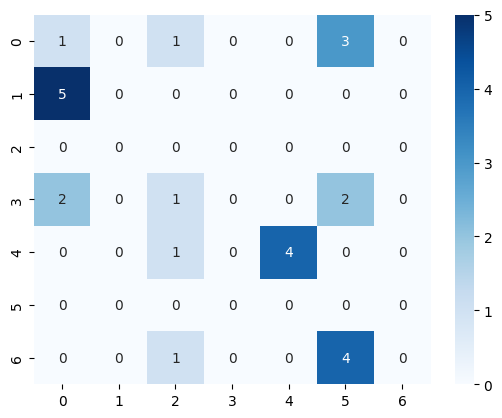

In [30]:
unknowns = librosa.util.find_files('Genre_Samples_Converted')

# run each model against the new files
for model in modelnames:
  clf = cf_dict[model]
  clf.fit(Xtrain,Ytrain)
  predicted = clf.predict(Xvalid)
  testing_accuracy = clf.score(Xvalid[:25], Yvalid[:25])

  for i in range(28):
    file = unknowns[i]
    pathsplit = file.split("\\")
    songfile = pathsplit[len(pathsplit)-1]
    print(i,"Actual:",Yvalid[i],"| Predicted:",predicted[i],'|',songfile[0:25])
  
  print("Accuracy of", model, "is", round(testing_accuracy * 100, 1), "%")

  cf_matrix = metrics.confusion_matrix(Yvalid[:25], predicted[:25])
  sns.heatmap(cf_matrix, annot=True, cmap='Blues')
  plt.show()
